In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import hmean, norm
from nltk import word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.probability import FreqDist
from collections import Counter
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
from statistics import harmonic_mean

In [2]:
tokenizer = RegexpTokenizer(r"\w+")

In [3]:
pd.set_option('max_colwidth', None)

In [4]:
squad = dataset = load_dataset("squad", split = "train")
squad_v2 = dataset = load_dataset("squad_v2", split = "train")

Reusing dataset squad (/home/sasha/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)
Reusing dataset squad_v2 (/home/sasha/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)


In [5]:
squad_df = pd.json_normalize(squad)
squad2_df= pd.json_normalize(squad_v2)

In [6]:
squad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87599 entries, 0 to 87598
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    87599 non-null  object
 1   title                 87599 non-null  object
 2   context               87599 non-null  object
 3   question              87599 non-null  object
 4   answers.text          87599 non-null  object
 5   answers.answer_start  87599 non-null  object
dtypes: object(6)
memory usage: 4.0+ MB


In [7]:
squad2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130319 entries, 0 to 130318
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    130319 non-null  object
 1   title                 130319 non-null  object
 2   context               130319 non-null  object
 3   question              130319 non-null  object
 4   answers.text          130319 non-null  object
 5   answers.answer_start  130319 non-null  object
dtypes: object(6)
memory usage: 6.0+ MB


In [8]:
squad_df['answers.text'] = squad_df['answers.text'].apply(lambda x : ''.join(x))
squad2_df['answers.text'] = squad2_df['answers.text'].apply(lambda x : ''.join(x))

In [9]:
squad_diff= pd.concat([squad2_df[['context','question','answers.text']],squad_df[['context','question','answers.text']]]).drop_duplicates(keep=False)
squad_diff.shape

(44197, 3)

In [10]:
print("Whereas the difference in dimensions between the two datasets is: " + str(130319-87599))

Whereas the difference in dimensions between the two datasets is: 42720


In [28]:
print ("SQuAD v2 train is supposed to have 43,498 negative examples")

SQuAD v2 train is supposed to have 43,498 negative examples


In [26]:
44197- 42720

1477

In [33]:
squad_df[['context','question','answers.text']][squad_df['question'].str.contains("When did Beyoncé release her first solo album?")]

,context,question,answers.text
288,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles ""Crazy in Love"" and ""Baby Boy"".",When did Beyoncé release her first solo album?,2003
409,"Beyoncé's first solo recording was a feature on Jay Z's ""'03 Bonnie & Clyde"" that was released in October 2002, peaking at number four on the U.S. Billboard Hot 100 chart. Her first solo album Dangerously in Love was released on June 24, 2003, after Michelle Williams and Kelly Rowland had released their solo efforts. The album sold 317,000 copies in its first week, debuted atop the Billboard 200, and has since sold 11 million copies worldwide. The album's lead single, ""Crazy in Love"", featuring Jay Z, became Beyoncé's first number-one single as a solo artist in the US. The single ""Baby Boy"" also reached number one, and singles, ""Me, Myself and I"" and ""Naughty Girl"", both reached the top-five. The album earned Beyoncé a then record-tying five awards at the 46th Annual Grammy Awards; Best Contemporary R&B Album, Best Female R&B Vocal Performance for ""Dangerously in Love 2"", Best R&B Song and Best Rap/Sung Collaboration for ""Crazy in Love"", and Best R&B Performance by a Duo or Group with Vocals for ""The Closer I Get to You"" with Luther Vandross.",When did Beyoncé release her first solo album?,"June 24, 2003"


In [34]:
squad2_df[['context','question','answers.text']][squad2_df['question'].str.contains("When did Beyoncé release her first solo album?")]

,context,question,answers.text
135,"Beyoncé's first solo recording was a feature on Jay Z's ""'03 Bonnie & Clyde"" that was released in October 2002, peaking at number four on the U.S. Billboard Hot 100 chart. Her first solo album Dangerously in Love was released on June 24, 2003, after Michelle Williams and Kelly Rowland had released their solo efforts. The album sold 317,000 copies in its first week, debuted atop the Billboard 200, and has since sold 11 million copies worldwide. The album's lead single, ""Crazy in Love"", featuring Jay Z, became Beyoncé's first number-one single as a solo artist in the US. The single ""Baby Boy"" also reached number one, and singles, ""Me, Myself and I"" and ""Naughty Girl"", both reached the top-five. The album earned Beyoncé a then record-tying five awards at the 46th Annual Grammy Awards; Best Contemporary R&B Album, Best Female R&B Vocal Performance for ""Dangerously in Love 2"", Best R&B Song and Best Rap/Sung Collaboration for ""Crazy in Love"", and Best R&B Performance by a Duo or Group with Vocals for ""The Closer I Get to You"" with Luther Vandross.",When did Beyoncé release her first solo album?,"June 24, 2003"


In [25]:
squad_diff[['context','question','answers.text']][squad_diff['answers.text']!= ""]

,context,question,answers.text
277,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles ""Crazy in Love"" and ""Baby Boy"".",In what city did Beyonce grow up?,Houston
278,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles ""Crazy in Love"" and ""Baby Boy"".",What was the name of Beyonce's first solo album?,Dangerously in Love
279,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles ""Crazy in Love"" and ""Baby Boy"".",On what date was Beyonce born?,"September 4, 1981"
280,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles ""Crazy in Love"" and ""Baby Boy"".",What is Beyonce's full name?,Beyoncé Giselle Knowles-Carter
288,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles ""Crazy in Love"" and ""Baby Boy"".",When did Beyoncé release her first solo album?,2003
...,...,...,...
86306,"In China, Yellow Emperor is regarded as the humanistic primogenitor.[citation needed] Sage kings such as Yao and Shun are humanistic figures as rec

In [16]:
squad_diff['answers.text'].value_counts()

                                                                                                                          43492
Thomas Jefferson                                                                                                              4
five                                                                                                                          4
matter                                                                                                                        3
Hokkien speakers                                                                                                              3
                                                                                                                          ...  
information from various perspectives, including psychology, biology, history, sociology, education, and anthropology.        1
preparation of children for adult roles.                                                                

In [35]:
squad_diff.sort_values(by=['answers.text'], ascending=False).head(10)

,context,question,answers.text
30930,"Antarctica, on average, is the coldest, driest, and windiest continent, and has the highest average elevation of all the continents. Antarctica is considered a desert, with annual precipitation of only 200 mm (8 in) along the coast and far less inland. The temperature in Antarctica has reached −89.2 °C (−128.6 °F), though the average for the third quarter (the coldest part of the year) is −63 °C (−81 °F). There are no permanent human residents, but anywhere from 1,000 to 5,000 people reside throughout the year at the research stations scattered across the continent. Organisms native to Antarctica include many types of algae, bacteria, fungi, plants, protista, and certain animals, such as mites, nematodes, penguins, seals and tardigrades. Vegetation, where it occurs, is tundra.",What is Antarctica's average temperature during the coldest part of the year?,−63 °C (−81 °F)
38422,"The Hellenistic period covers the period of ancient Greek (Hellenic) history and Mediterranean history between the death of Alexander the Great in 323 BC and the emergence of the Roman Empire as signified by the Battle of Actium in 31 BC and the subsequent conquest of Ptolemaic Egypt the following year. At this time, Greek cultural influence and power was at its peak in Europe, Africa and Asia, experiencing prosperity and progress in the arts, exploration, literature, theatre, architecture, music, mathematics, philosophy, and science. For example, competitive public games took place, ideas in biology, and popular entertainment in theaters. It is often considered a period of transition, sometimes even of decadence or degeneration, compared to the enlightenment of the Greek Classical era. The Hellenistic period saw the rise of New Comedy, Alexandrian poetry, the Septuagint and the philosophies of Stoicism and Epicureanism. Greek Science was advanced by the works of the mathematician Euclid and the polymath Archimedes. The religious sphere expanded to include new gods such as the Greco-Egyptian Serapis, eastern deities such as Attis and Cybele and the Greek adoption of Buddhism.",dd,yptian Se
38676,"During the Hellenistic period, Judea became a frontier region between the Seleucid Empire and Ptolemaic Egypt and therefore was often the frontline of the Syrian wars, changing hands several times during these conflicts. Under the Hellenistic kingdoms, Judea was ruled by the hereditary office of the High Priest of Israel as a Hellenistic vassal. This period also saw the rise of a Hellenistic Judaism, which first developed in the Jewish diaspora of Alexandria and Antioch, and then spread to Judea. The major literary product of this cultural syncretism is the Septuagint translation of the Hebrew Bible from Biblical Hebrew and Biblical Aramaic to Koiné Greek. The reason for the production of this translation seems to be that many of the Alexandrian Jews had lost the ability to speak Hebrew and Aramaic.",I couldn't could up with another question. But i need to fill this space because I can't submit the hit.,y of
74205,"All states have a geographic scope of interests, actions, or projected power. This is a crucial factor in distinguishing a great power from a regional power; by definition the scope of a regional power is restricted to its region. It has been suggested that a great power should be possessed of actual influence throughout the scope of the prevailing international system. Arnold J. Toynbee, for example, observes that ""Great power may be defined as a political force exerting an effect co-extensive with the widest range of the society in which it operates. The Great powers of 1914 were 'world-powers' because Western society had recently become 'world-wide'.""",What were the great powers of 1914 called?,world-powers
46828,"London is a leading global city, with strengths in the arts, commerce, education, entertainment, fashion, finance, healthcare, media, professional services, research and development, tourism, and tr

In [22]:
alllist=[sent for sent in squad_df.context]
corp= ' '. join(s for s in alllist)
vocab = FreqDist(word.lower() for word in tokenizer.tokenize(corp))
print("There are " + str(len(vocab)) + " words including stop words")

There are 78880 words including stop words


In [23]:
alllist=[sent for sent in squad2_df.context]
corp= ' '. join(s for s in alllist)
vocab = FreqDist(word.lower() for word in tokenizer.tokenize(corp))
print("There are " + str(len(vocab)) + " words including stop words")

There are 79265 words including stop words


In [25]:
def Zipf_plot(dataframe):
    """
    This function plots the correspondence of the distribution of terms
    generated by count_vocab_frequencies with the projected Zipf's law
    distribution.
    s is the value of the exponent characterizing the distribution, currently at 1.
    # TODO : see if changing this makes the distribution fit better -- 
    e.g. When Zipf's law is checked for cities, a better fit has been found with exponent s = 1.07
    """
    y_pos = np.arange(500)
    plt.figure(figsize=(10,8))
    s = 1
    expected_zipf = [dataframe.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
    plt.bar(y_pos, dataframe.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
    plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
    plt.ylabel('Frequency')
    plt.title("Top 500 tokens in the dataset, with Zipf's law in dotted red")

In [31]:
def count_vocab_frequencies(dataframe,col):
    """
    Based on an input pandas DataFrame with a 'col' column, 
    this function will count the occurrences of ALL words 
    (no stop word removal) and will return another DataFrame
    with the rows corresponding to the different vocabulary words
    and the column to the total count of that word.
    """
    cvec = CountVectorizer(token_pattern=u"(?u)\\b\\w+\\b")
    #needed to modify the minimum token length : https://stackoverflow.com/questions/33260505/countvectorizer-ignoring-i
    cvec.fit(dataframe[col])
    document_matrix = cvec.transform(dataframe[col])
    batches = np.linspace(0,dataframe.shape[0],100).astype(int)
    i=0
    tf = []
    while i < len(batches)-1:
        batch_result = np.sum(document_matrix[batches[i]:batches[i+1]].toarray(),axis=0)
        tf.append(batch_result)
        i += 1
    term_freq_df = pd.DataFrame([np.sum(tf,axis=0)],columns=cvec.get_feature_names()).transpose()
    term_freq_df.columns=['total']
    return(term_freq_df)

In [27]:
def Zipf_check_words(dataframe, num_words):
    """
    Checks the Zipf's law of the top [num_words] most frequent words in dataframe.
    Returns a dataframe with 3 columns:
    total = the raw number of counts 
    zipf = the projected counts according to Zipf
    difference = the *percentage* difference between the two
    """
    s = 1
    terms = pd.DataFrame(dataframe.sort_values(by='total', ascending=False)['total'][:num_words])
    expected_zipf=[dataframe.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in np.arange(num_words)]
    terms['zipf'] = [int(z) for z in expected_zipf]
    terms['difference'] = terms.apply(lambda x: ((x['total']- x['zipf'])/x['zipf']* 100), axis=1)
    return(terms)

In [32]:
term_df= count_vocab_frequencies(squad_df,'context')

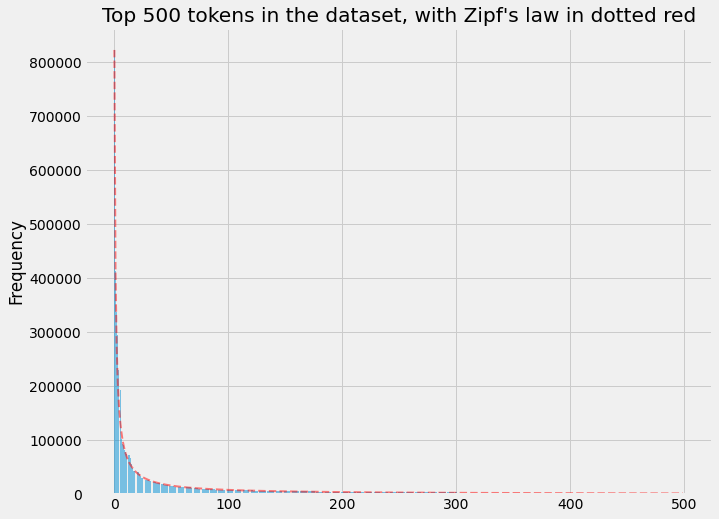

In [33]:
Zipf_plot(term_df)

In [34]:
term_df= count_vocab_frequencies(squad2_df,'context')

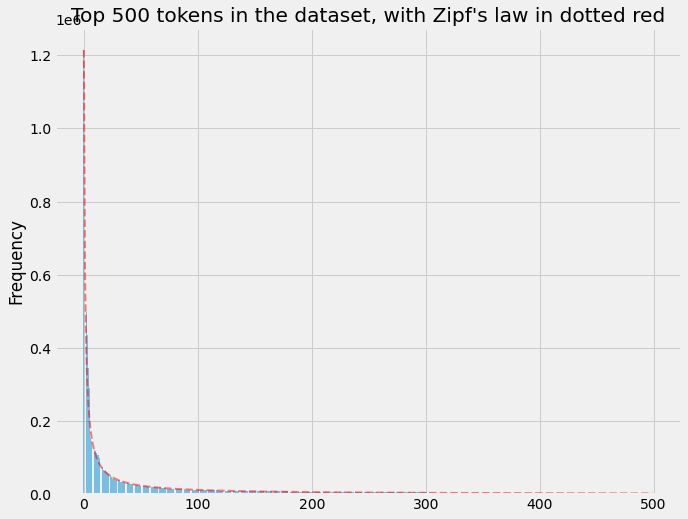

In [35]:
Zipf_plot(term_df)

In [36]:
def check_open_class(dataframe, threshold, closedlist):
    closedclass= dataframe[dataframe.index.isin(closedlist)]
    openclass= dataframe[~dataframe.index.isin(closedlist)]
    openclassthreshold= openclass.loc[(openclass['difference'] >=threshold)]
    print("There are: "+ str(openclassthreshold.shape[0])+ " closed class words that are above the %s threshold" %(threshold))
    return(openclassthreshold.sort_values(by='difference', ascending=False))

In [44]:
def check_closed_class(dataframe, threshold, closedlist):
    '''
    Based on a dataframe and a threshold, checks how many closed-class 
    words are above the threshold, and returns the dataframe sorted by 
    difference.
    '''
    closedclass= dataframe[dataframe.index.isin(closedlist)]
    closedclassthreshold= closedclass.loc[(closedclass['difference'] >=threshold)]
    print("There are: "+ str(closedclassthreshold.shape[0])+ " closed class words that are above the %s threshold" %(threshold))
    return(closedclassthreshold.sort_values(by='difference', ascending=False))

In [37]:
#Creating the closed word list from the txt file
en_wordlist=open('../resources/closed_EN.txt', 'r').readlines()
en_closedlist=[]
for l in en_wordlist:
    en_closedlist= en_closedlist + (l.split())
print("There are: "+ str(len(en_closedlist)) + " closed-class words in English.")

There are: 312 closed-class words in English.


#### Getting more information

#### Checking for missing values

In [14]:
datadf[datadf.isnull().any(axis=1)].head()

,id,translation.fr,translation.ru


In [15]:
np.sum(datadf.isnull().any(axis=1))

0

#### Count vocab size + frequencies

In [34]:
term_df= count_vocab_frequencies(datadf,'translation.en')

In [36]:
term_df_fr= count_vocab_frequencies(datadf,'translation.fr')

#### Zipf's law plot

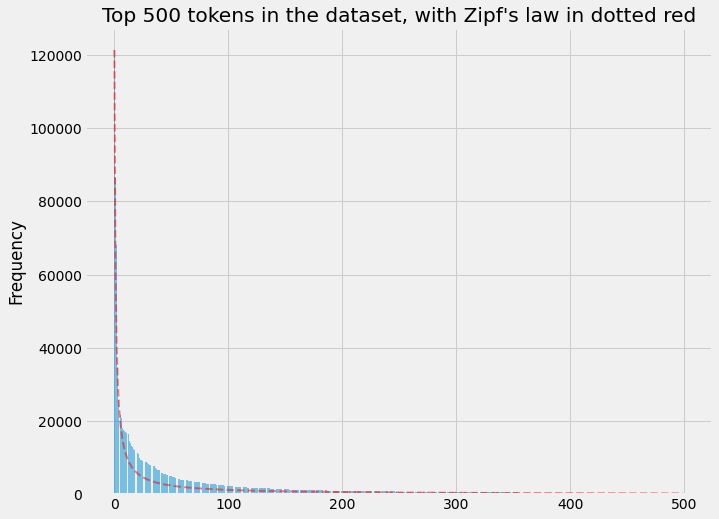

In [35]:
Zipf_plot(term_df)

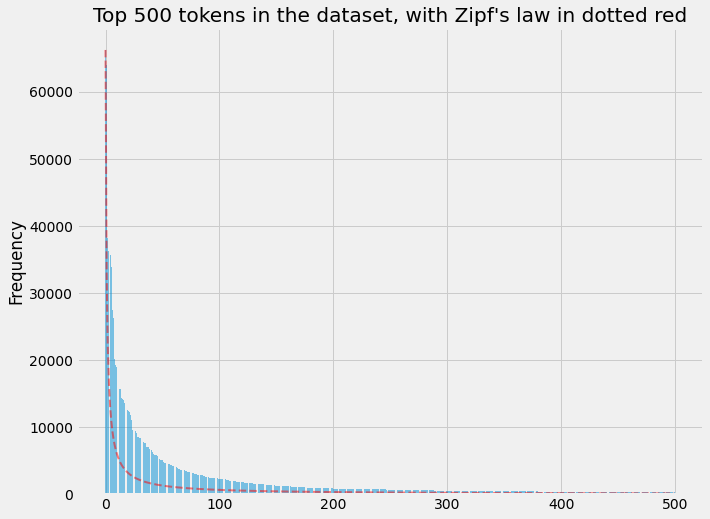

In [37]:
Zipf_plot(term_df_fr)

### Checking which words do not respect Zipf's law

In [38]:
zipf_df= Zipf_check_words(term_df,500)

In [39]:
zipf_df.loc[(zipf_df['difference'] >=100)].head(10)

,total,zipf,difference
unto,8999,4495,100.200222
was,8827,4335,103.621684
have,8730,4185,108.602151
god,8586,4046,112.209590
me,8175,3915,108.812261
but,7951,3793,109.622990
their,7938,3678,115.823817
said,7925,3570,121.988796
from,7829,3468,125.749712
which,7653,3371,127.024622


In [40]:
zipf_df_fr= Zipf_check_words(term_df_fr,500)

In [41]:
zipf_df_fr.loc[(zipf_df_fr['difference'] >=100)].head(10)

,total,zipf,difference
l,36275,16547,119.224029
le,35632,13237,169.184861
les,33810,11031,206.499864
à,27432,9455,190.132205
il,26238,8273,217.152182
qui,20214,7354,174.870819
des,19231,6618,190.586280
d,18977,6017,215.389729
que,18229,5515,230.534905
est,15644,5091,207.287370


### Checking open versus closed class words

In [50]:
check_closed_class(zipf_df,100,en_closedlist)

There are: 28 closed class words that are above the 100 threshold


,total,zipf,difference
which,7653,3371,127.024622
from,7829,3468,125.749712
on,6706,3034,121.028345
are,6510,2960,119.932432
who,7191,3280,119.237805
as,6750,3112,116.902314
their,7938,3678,115.823817
but,7951,3793,109.622990
me,8175,3915,108.812261
have,8730,4185,108.602151


In [57]:
check_closed_class(zipf_df_fr,100,fr_closedlist)

There are: 145 closed class words that are above the 100 threshold


,total,zipf,difference
une,7615,1838,314.309032
nous,7008,1697,312.964054
du,11816,2877,310.705596
leur,5778,1408,310.369318
ils,12240,3008,306.914894
...,...,...,...
quoi,336,150,124.000000
avais,318,142,123.943662
eu,294,133,121.052632
celle,296,134,120.895522


In [55]:
check_open_class(zipf_df,100,en_closedlist)

There are: 21 closed class words that are above the 100 threshold


,total,zipf,difference
said,7925,3570,121.988796
yahweh,6840,3194,114.151534
god,8586,4046,112.209590
king,5086,2427,109.559126
man,5104,2477,106.055713
went,2774,1348,105.786350
thy,4602,2247,104.806409
son,4778,2334,104.712939
israel,5157,2528,103.995253
came,3802,1867,103.642207


In [58]:
check_open_class(zipf_df_fr,100,fr_closedlist)

There are: 352 closed class words that are above the 100 threshold


,total,zipf,difference
s,6572,1614,307.187113
comme,5850,1438,306.815021
fils,8341,2068,303.336557
se,7740,1946,297.738952
car,6230,1575,295.555556
...,...,...,...
samuel,294,134,119.402985
aucune,296,135,119.259259
assignation,296,135,119.259259
l,36275,16547,119.224029


In [ ]:
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, RegexpTokenizer

In [68]:
en_alllist=[sent for sent in datadf['translation.en']]
corp= ' '. join(s for s in en_alllist)
tokenizer = RegexpTokenizer(r"\w+")
vocab = FreqDist(word.lower() for word in tokenizer.tokenize(corp))
print("There are " + str(len(vocab)) + " words including stop words in English")

There are 15894 words including stop words in English


In [69]:
fr_alllist=[sent for sent in datadf['translation.fr']]
corp= ' '. join(s for s in fr_alllist)
tokenizer = RegexpTokenizer(r"\w+")
vocab = FreqDist(word.lower() for word in tokenizer.tokenize(corp))
print("There are " + str(len(vocab)) + " words including stop words in French")

There are 20532 words including stop words in French


In [71]:
import statistics

In [76]:
total_lens = 0
alllengths=[]
for i, sent in enumerate(en_alllist):
    lent=len(tokenizer.tokenize(sent))
    alllengths.append(lent)
    total_lens += lent
avg_sent_len = total_lens / i
print("The average English sentence length is: " + str(round(avg_sent_len,4)) + " words.")
print("The mean sentence English length is: " + str(statistics.mean(alllengths)) + " words.")
print("The median sentence English length is: " + str(statistics.median(alllengths)) + " words.")

The average English sentence length is: 25.0684 words.
The mean sentence English length is: 25.068027976525443 words.
The median sentence English length is: 23 words.


In [78]:
total_lens = 0
alllengths=[]
for i, sent in enumerate(fr_alllist):
    lent=len(tokenizer.tokenize(sent))
    alllengths.append(lent)
    total_lens += lent
avg_sent_len = total_lens / i
print("The average French sentence length is: " + str(round(avg_sent_len,4)) + " words.")
print("The mean sentence French length is: " + str(statistics.mean(alllengths)) + " words.")
print("The median sentence French length is: " + str(statistics.median(alllengths)) + " words.")

The average French sentence length is: 25.171 words.
The mean sentence French length is: 25.170576412894928 words.
The median sentence French length is: 23 words.


### Weird stuff

In [31]:
squad_df[['context','question','answers.text']][squad_df['question'].str.contains("I couldn't could up with another question. But i need to fill this space because I can't submit the hit.")]

,context,question,answers.text
38466,"The major issue with the term Hellenistic lies in its convenience, as the spread of Greek culture was not the generalized phenomenon that the term implies. Some areas of the conquered world were more affected by Greek influences than others. The term Hellenistic also implies that the Greek populations were of majority in the areas in which they settled, while in many cases, the Greek settlers were actually the minority among the native populations. The Greek population and the native population did not always mix; the Greeks moved and brought their own culture, but interaction did not always occur.",I couldn't could up with another question. But i need to fill this space because I can't submit the hit.,moved
38536,"Sparta remained independent, but it was no longer the leading military power in the Peloponnese. The Spartan king Cleomenes III (235–222 BCE) staged a military coup against the conservative ephors and pushed through radical social and land reforms in order to increase the size of the shrinking Spartan citizenry able to provide military service and restore Spartan power. Sparta's bid for supremacy was crushed at the Battle of Sellasia (222) by the Achaean league and Macedon, who restored the power of the ephors.",I couldn't could up with another question. But i need to fill this space because I can't submit the hit.,refor
38546,"One of the few city states who managed to maintain full independence from the control of any Hellenistic kingdom was Rhodes. With a skilled navy to protect its trade fleets from pirates and an ideal strategic position covering the routes from the east into the Aegean, Rhodes prospered during the Hellenistic period. It became a center of culture and commerce, its coins were widely circulated and its philosophical schools became one of the best in the mediterranean. After holding out for one year under siege by Demetrius Poliorcetes (304-305 BCE), the Rhodians built the Colossus of Rhodes to commemorate their victory. They retained their independence by the maintenance of a powerful navy, by maintaining a carefully neutral posture and acting to preserve the balance of power between the major Hellenistic kingdoms.",I couldn't could up with another question. But i need to fill this space because I can't submit the hit.,tes (3
38676,"During the Hellenistic period, Judea became a frontier region between the Seleucid Empire and Ptolemaic Egypt and therefore was often the frontline of the Syrian wars, changing hands several times during these conflicts. Under the Hellenistic kingdoms, Judea was ruled by the hereditary office of the High Priest of Israel as a Hellenistic vassal. This period also saw the rise of a Hellenistic Judaism, which first developed in the Jewish diaspora of Alexandria and Antioch, and then spread to Judea. The major literary product of this cultural syncretism is the Septuagint translation of the Hebrew Bible from Biblical Hebrew and Biblical Aramaic to Koiné Greek. The reason for the production of this translation seems to be that many of the Alexandrian Jews had lost the ability to speak Hebrew and Aramaic.",I couldn't could up with another question. But i need to fill this space because I can't submit the hit.,y of
38704,"After the death of Menander (c. 130 BC), the Kingdom appears to have fragmented, with several 'kings' attested contemporaneously in different regions. This inevitably weakened the Greek position, and territory seems to have been lost progressively. Around 70 BC, the western regions of Arachosia and Paropamisadae were lost to tribal invasions, presumably by those tribes responsible for the end of the Bactrian kingdom. The resulting Indo-Scythian kingdom seems to have gradually pushed the remaining Indo-Greek kingdom towards the east. The Indo-Greek kingdom appears to have lingered on in western Punjab until about 10 AD when finally ended by the Indo-Scythians.",I couldn't could up with another question. But i need to fil